# BA870 Individual Project
## Name: Yesol Lee
## Email: yesollee@bu.edu

The goal of this project is to use data analytics in finance domain. In this project, I will use and manipulate various data collected from WRDS to analyze companies's performance in the beginning of 2022.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning packages used in imputation stage
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# regression for financial analysis
import statsmodels.api as sm

# winsorize to handle outliers in financial ratios
from scipy.stats.mstats import winsorize

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# load necessary datasets

# ProjectTickers data which has our target variable, RetYTD
target = pd.read_csv("/content/ProjectTickers.csv")

# 5 years monthly Fama French Risk Factors (2017-2021)
ff_factors = pd.read_csv("/content/Project-2017-21-FF Risk Factors.csv")

# 5 years of monthly stock return (2017-2021)
returns = pd.read_csv("/content/Project-2017-21-Returns.csv")

# financial statmenet data (2021)
financials = pd.read_csv("/content/Project-2021-Financials.csv")

# GICS industry group data (2021)
industry = pd.read_csv("/content/Project-2021-Sector.csv")

# Data Overview

## Target
* Ticker: ticker name
* Name: Company name
* RetYTD: Return between January 1st 2022 to April 14th 2022

In [ ]:
# check data information
target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Ticker  1886 non-null   object 
 1   Name    1886 non-null   object 
 2   RetYTD  1886 non-null   float64
dtypes: float64(1), object(2)
memory usage: 44.3+ KB


In [ ]:
# check missing values
target.isna().sum()

Ticker    0
Name      0
RetYTD    0
dtype: int64

In [ ]:
# check the number of unique ticker
target.Ticker.nunique()

1886

The goal of this project is to predict stock return of 1886 companies in 2022. 01. 01 ~ 2022. 04. 15. The target variable is RetYTD.

## Fama French Factors
* dateff: date
* mktrf: market return
* smb: size risk factor
* hml: value risk factor
* rf: risk free return

In [ ]:
# check the data information
# monthly FF factor data for 5 years
ff_factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   dateff  60 non-null     int64  
 1   mktrf   60 non-null     float64
 2   smb     60 non-null     float64
 3   hml     60 non-null     float64
 4   rf      60 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 2.5 KB


In [ ]:
# check the missing values
ff_factors.isna().sum()

dateff    0
mktrf     0
smb       0
hml       0
rf        0
dtype: int64

## Returns
* PERMNO: unique identifier of companies
* date: measured date
* TICKER: ticker name of companies
* RET: Monthly return of the stock

In [ ]:
# check the data information
returns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114715 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   PERMNO  114715 non-null  int64 
 1   date    114715 non-null  int64 
 2   TICKER  114653 non-null  object
 3   RET     114700 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.5+ MB


We can see that RET column is Object data type. Return of stocks is usually recorded in numeric form. So there is possibility that there are some datapoints has inappropriate records. I will investigate this column and do necessary data cleaning in the next step.

In [ ]:
# check the number of unique ticker
returns.TICKER.nunique()

1924

The returns data has 1924 unique tickers. There might be some companies chaged ticker symbol due to their business decision such as M&A and so on.

In [ ]:
# checking missing values
returns.isna().sum()

PERMNO     0
date       0
TICKER    62
RET       15
dtype: int64

We can see that there are 62 missing values in TICKER column and 15 in RET column.

## Financials
* tic: ticker
* act: Current Asset - Total
* at: Assets - Total
* ceq: Common/Ordinary Equity - Total
* cogs: Cost of Goods Sold
* csho: Common Share Outstanding
* invt: Inventories - Total
* lct: Current Liability - Total
* lt: Liabilities - Total
* ni: Net Income
* re: retained earning
* revt: Revenue - Total
* prcc_c: Price Close


In [ ]:
# check data information
financials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 22 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   gvkey     1886 non-null   int64  
 1   datadate  1886 non-null   int64  
 2   fyear     1886 non-null   int64  
 3   indfmt    1886 non-null   object 
 4   consol    1886 non-null   object 
 5   popsrc    1886 non-null   object 
 6   datafmt   1886 non-null   object 
 7   tic       1886 non-null   object 
 8   curcd     1886 non-null   object 
 9   act       1431 non-null   float64
 10  at        1886 non-null   float64
 11  ceq       1886 non-null   float64
 12  cogs      1886 non-null   float64
 13  csho      1886 non-null   float64
 14  invt      1852 non-null   float64
 15  lct       1431 non-null   float64
 16  lt        1881 non-null   float64
 17  ni        1886 non-null   float64
 18  re        1883 non-null   float64
 19  revt      1886 non-null   float64
 20  costat    1886 non-null   obje

In [ ]:
# check the number of unique ticker symbol
financials.tic.nunique()

1886

The financials data match the number of ticker symbols in the target data.

In [ ]:
# check missing values
financials.isna().sum()

gvkey         0
datadate      0
fyear         0
indfmt        0
consol        0
popsrc        0
datafmt       0
tic           0
curcd         0
act         455
at            0
ceq           0
cogs          0
csho          0
invt         34
lct         455
lt            5
ni            0
re            3
revt          0
costat        0
prcc_c        0
dtype: int64

There are 455 missing values in current assets and current liabilities columns. Invt, lt, and re columns have considerably few missing values. I will impute these missing values by using accounting rule and machine learning method later on.

## Industry
* tic: ticker name
* ggroup: GICS Industry Group

In [ ]:
# check the data information
industry.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   gvkey     1886 non-null   int64 
 1   datadate  1886 non-null   int64 
 2   fyear     1886 non-null   int64 
 3   indfmt    1886 non-null   object
 4   consol    1886 non-null   object
 5   popsrc    1886 non-null   object
 6   datafmt   1886 non-null   object
 7   tic       1886 non-null   object
 8   curcd     1886 non-null   object
 9   costat    1886 non-null   object
 10  ggroup    1886 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 162.2+ KB


In [ ]:
# check the number of unique ticker in the data
industry.tic.nunique()

1886

In [ ]:
# check the missing value
industry.isna().sum()

gvkey       0
datadate    0
fyear       0
indfmt      0
consol      0
popsrc      0
datafmt     0
tic         0
curcd       0
costat      0
ggroup      0
dtype: int64

# Data Cleaning

Before I start analysis, I firstly cleaned the data. This is done by cleaning **column names - Subsetting only necessary columns - Changing data type into proper format.**



## Cleaning Column Names
I will firstly clean column names of each data set. The purpose of this is to make dataset more convenient.

In [ ]:
# lower column names
# I will lower the column names of industry and target dataframes to standardize case as other data frames

industry.columns = industry.columns.str.lower()
target.columns = target.columns.str.lower()
returns.columns = returns.columns.str.lower()

In [ ]:
# standardize column name for ticker in all datasets for merge
# I have ticker columns in industry, financials, return and target dataframes.
# But some of dataframe have different name for that column.
# I will change column name into "tic" so all dataframe can have the same column name.

returns.rename(columns={"ticker":"tic"}, inplace=True)
target.rename(columns={"ticker":"tic"}, inplace=True)

In [ ]:
# dateff into date to match column name with returns data frame
ff_factors.rename(columns={'dateff':'date'}, inplace=True)

In [ ]:
# confirm column names are cleaned well
print(target.columns)
print(ff_factors.columns)
print(returns.columns)
print(financials.columns)
print(industry.columns)

Index(['tic', 'name ', 'retytd'], dtype='object')
Index(['date', 'mktrf', 'smb', 'hml', 'rf'], dtype='object')
Index(['permno', 'date', 'tic', 'ret'], dtype='object')
Index(['gvkey', 'datadate', 'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt',
       'tic', 'curcd', 'act', 'at', 'ceq', 'cogs', 'csho', 'invt', 'lct', 'lt',
       'ni', 're', 'revt', 'costat', 'prcc_c'],
      dtype='object')
Index(['gvkey', 'datadate', 'fyear', 'indfmt', 'consol', 'popsrc', 'datafmt',
       'tic', 'curcd', 'costat', 'ggroup'],
      dtype='object')


In [ ]:
# rename "name " in target dataset to "name"
target.rename(columns={"name ":"name"}, inplace=True)

## Subsetting only necessary columns
Data collected from WRDS includes additional columns like currency and so on. In this part I will subset columns that I will use only.

In [ ]:
financials = financials[["tic", "act", "at", "ceq", "cogs", "csho", "invt", "lct", "lt", "ni", "re", "revt", "prcc_c"]]
industry = industry[["tic", "ggroup"]]

## Data type

In the previous step, Data Overview, I found that ret column in the returns data which indicates the return of stock has object data type. Before changing data type, I will remove NaN value in return column, because those data points are not usuable in regression model.

In [ ]:
returns.dropna(subset=["ret"], inplace=True)

Now, I will investigate if there are any alphabetic records in the ret column before changing the datatype.

In [ ]:
returns[returns.ret.str.isalpha() == True]

,permno,date,tic,ret
33195,16497,20170131,CNDT,C
33255,16498,20170131,HGV,C
33315,16499,20170131,PK,C
33555,16543,20170131,VREX,C
33675,16554,20170131,JELD,C
...,...,...,...,...
111409,92683,20210730,NaN,B
111410,92683,20210831,NaN,B
111411,92683,20210930,NaN,B
111412,92683,20211029,NaN,B


In [ ]:
returns.ret.str.isalpha().value_counts()

False    114629
True         71
Name: ret, dtype: int64

We can see that there are 71 data points that has letter B, or C for return. These data are not usuable in regression model. So I will drop these columns.

In [ ]:
# remove alphabetical data
returns = returns[returns.ret.str.isalpha() == False]

# change data type into float
returns.loc[:, "ret"] = returns.ret.astype(float)

In [ ]:
# confirm the change
returns.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114629 entries, 0 to 114714
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   permno  114629 non-null  int64  
 1   date    114629 non-null  int64  
 2   tic     114629 non-null  object 
 3   ret     114629 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.4+ MB


In [ ]:
returns.isna().sum()

permno    0
date      0
tic       0
ret       0
dtype: int64

After dropping NaN value and changing the column type, the final shape of Return dataframe is 114629 * 4. This process also removed missing values in tic column.

# Imputation

Moving on, I will replace the missing values in financial data.

## Financials

In [ ]:
# check the missing values
financials.isna().sum()

tic         0
act       455
at          0
ceq         0
cogs        0
csho        0
invt       34
lct       455
lt          5
ni          0
re          3
revt        0
prcc_c      0
dtype: int64

act, invt, lct and lt column have missing values.

### Lt (total liability)
I will firstly remove missing value in lt, which is total liability by using accounting rule, asset = liability + equity.

In [ ]:
# check which rows need to be imputed
financials[financials["lt"].isna()]

,tic,act,at,ceq,cogs,csho,invt,lct,lt,ni,re,revt,prcc_c
7,ATRI,136.571,267.264,244.296,82.751,1.801,50.778,13.346,NaN,33.055,357.324,165.009,704.90
43,BMI,261.360,530.818,403.070,271.852,29.250,99.611,82.146,NaN,60.884,353.671,505.198,106.56
191,GNTX,872.976,2131.391,1937.988,1012.350,236.441,316.267,181.656,NaN,360.797,1044.389,1731.170,34.85
379,APPS,97.385,260.369,145.012,175.867,89.950,0.000,111.149,NaN,54.884,-228.237,313.579,56.56
787,TRUP,390.954,562.582,332.200,592.345,40.475,0.000,223.696,NaN,-35.530,-123.813,698.991,132.03


In [ ]:
# make a list of index number
lt_imput_list = [7, 43, 191, 379, 787]

In [ ]:
# liability = asset - equity
financials.loc[lt_imput_list,"lt"] = financials.loc[lt_imput_list,"at"] - \
financials.loc[lt_imput_list,"ceq"]

In [ ]:
# confirm all missing values are replaced
financials["lt"].isna().sum()

0

In [ ]:
# confirm all missing values are replaced
financials.loc[lt_imput_list,:]

,tic,act,at,ceq,cogs,csho,invt,lct,lt,ni,re,revt,prcc_c
7,ATRI,136.571,267.264,244.296,82.751,1.801,50.778,13.346,22.968,33.055,357.324,165.009,704.90
43,BMI,261.360,530.818,403.070,271.852,29.250,99.611,82.146,127.748,60.884,353.671,505.198,106.56
191,GNTX,872.976,2131.391,1937.988,1012.350,236.441,316.267,181.656,193.403,360.797,1044.389,1731.170,34.85
379,APPS,97.385,260.369,145.012,175.867,89.950,0.000,111.149,115.357,54.884,-228.237,313.579,56.56
787,TRUP,390.954,562.582,332.200,592.345,40.475,0.000,223.696,230.382,-35.530,-123.813,698.991,132.03


### ACT (Current Asset)

From now on, I will use machine learning models to predict missing values.

In [ ]:
# generate subset of data frame that has missing values in act column
act_imput_target = financials[financials["act"].isna()]
act_imput_target

,tic,act,at,ceq,cogs,csho,invt,lct,lt,ni,re,revt,prcc_c
9,ALX,NaN,1391.965,252.589,124.027,5.107,0.000,NaN,1139.376,132.930,214.369,206.148,260.30
14,PRI,NaN,16123.223,2082.512,2039.968,39.368,24.355,NaN,14033.440,373.357,2076.894,2709.732,153.27
17,AXP,NaN,188548.000,22177.000,31847.000,761.000,0.000,NaN,166371.000,8060.000,10529.000,43663.000,163.60
18,AFL,NaN,157542.000,33253.000,16433.000,652.132,0.000,NaN,124289.000,4325.000,48774.000,21037.000,58.39
19,AIG,NaN,596112.000,65471.000,36091.000,818.687,0.000,NaN,527200.000,9388.000,30472.000,52046.000,56.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,TPH,NaN,4336.223,2447.621,2962.169,109.644,3054.743,NaN,1888.590,469.267,2355.448,3982.235,27.89
1873,NTB,NaN,15335.200,977.493,21.963,49.292,0.691,NaN,14357.707,162.668,-20.588,520.744,38.11
1875,TRTN,NaN,12643.838,2334.712,135.730,65.866,0.000,NaN,9579.126,530.240,1952.035,1676.849,60.23
1880,CNS,NaN,492.687,255.183,319.368,48.270,23.711,NaN,148.361,211.396,-237.853,583.832,92.51


In [ ]:
# generate subset of data that will be used in model training
act_imput_train = financials.drop(act_imput_target.index)
act_imput_train.shape

(1431, 13)

In [ ]:
# X and y
act_X = act_imput_train.drop(columns=["tic", "invt","lct", "act", "prcc_c", "csho", "re"])
act_y = act_imput_train["act"]

In [ ]:
# train-test split
# I will use 50% of data as holdout set to validate model before imputation
act_X_train, act_X_test, act_y_train, act_y_test = train_test_split(
    act_X, act_y, test_size=0.5, random_state=870)

In [ ]:
# initiate and fit the model
reg_act = LinearRegression()
reg_act.fit(act_X_train, act_y_train)

# check r sqaured to see model explains much variation in the data
r2_train_act = r2_score(act_y_train, reg_act.predict(act_X_train))
r2_test_act = r2_score(act_y_test, reg_act.predict(act_X_test))

print("The train R squared is {}, and test R squared is {}".format(r2_train_act, r2_test_act))

The train R squared is 0.7936122397978844, and test R squared is 0.6251992129075392


The linear regression model have R square of 79.36% on train data, and 62.52 on test data.

In [ ]:
# make prediction
act_target_pred = reg_act.predict(act_imput_target.drop(columns=["tic", "invt","lct", "act", "prcc_c", "csho", "re"]))

In [ ]:
# add result in the data

for index in act_imput_target.index:
  pred_index = 0
  financials.loc[index, "act"] = act_target_pred[pred_index]
  pred_index += 1

In [ ]:
# confirm if all missing values are imputed
financials.act.isna().sum()

0

### Invt (Inventory)

In [ ]:
# generate subset of data frame that has missing values in invt column
invt_imput_target = financials[financials["invt"].isna()]
invt_imput_target.head()

,tic,act,at,ceq,cogs,csho,invt,lct,lt,ni,re,revt,prcc_c
154,EQT,2286.766000,21607.388,10029.527,2699.997,376.399,NaN,5080.171,11561.625,-1155.759,-120.390,3064.663,21.81
177,BEN,674.996251,24168.400,11223.400,5942.000,501.808,NaN,NaN,11424.800,1831.200,11173.200,8400.200,33.49
204,HE,674.996251,15822.637,2390.884,2185.611,109.312,NaN,NaN,13397.460,248.056,705.388,2850.379,41.50
257,LNC,674.996251,387301.000,20272.000,17045.000,177.194,NaN,NaN,367029.000,1405.000,15537.000,18551.000,68.26
259,L,674.996251,81626.000,17846.000,11571.000,248.417,NaN,NaN,62451.000,1578.000,14962.000,13688.000,57.76


In [ ]:
# generate subset of data that will be used in model training
invt_imput_train = financials.drop(invt_imput_target.index)
invt_imput_train.shape

(1852, 13)

In [ ]:
# X and y
invt_X = invt_imput_train.drop(columns=["tic", "invt","lct", "prcc_c", "csho", "re"])
invt_y = invt_imput_train["invt"]

In [ ]:
# train-test split
invt_X_train, invt_X_test, invt_y_train, invt_y_test = train_test_split(
    invt_X, invt_y, test_size=0.5, random_state=870)

In [ ]:
# initiate and fit the model
reg_invt = LinearRegression()
reg_invt.fit(invt_X_train, invt_y_train)

# check r sqaured to see model explains much variation in the data
r2_train_invt1 = r2_score(invt_y_train, reg_invt.predict(invt_X_train))
r2_test_invt1 = r2_score(invt_y_test, reg_invt.predict(invt_X_test))

print("The train R squared is {}, and test R squared is {}".format(r2_train_invt1, r2_test_invt1))

The train R squared is 0.24365415413649072, and test R squared is 0.09117099403711815


When I tested out linear regression model, the R square on both train and test data were really low. So I will try another algorithm for comparison.

In [ ]:
# initiate and fit the model
rf_invt = RandomForestRegressor(max_depth=8, random_state=870, n_estimators=200, max_features="sqrt")
rf_invt.fit(invt_X_train, invt_y_train)

# check r sqaured to see model explains much variation in the data
r2_train_invt2 = r2_score(invt_y_train, rf_invt.predict(invt_X_train))
r2_test_invt2 = r2_score(invt_y_test, rf_invt.predict(invt_X_test))

print("The train R squared is {}, and test R squared is {}".format(r2_train_invt2, r2_test_invt2))

The train R squared is 0.854050695747021, and test R squared is 0.2535491296943949


The random forest model had a little higher r squared compared to the linear regression model. So I will use this model for imputation.

In [ ]:
# make prediction
invt_target_pred = rf_invt.predict(invt_imput_target.drop(columns=["tic", "invt","lct", "prcc_c", "csho", "re"]))

# add result in the data

for index in invt_imput_target.index:
  pred_index = 0
  financials.loc[index, "invt"] = invt_target_pred[pred_index]
  pred_index += 1

In [ ]:
# confirm missing values
financials.invt.isna().sum()

0

### LCT (Current Liability)

In [ ]:
# generate subset of data frame that has missing values in lct column
lct_imput_target = financials[financials["lct"].isna()]
lct_imput_target.head()

,tic,act,at,ceq,cogs,csho,invt,lct,lt,ni,re,revt,prcc_c
9,ALX,674.996251,1391.965,252.589,124.027,5.107,0.000,NaN,1139.376,132.930,214.369,206.148,260.30
14,PRI,674.996251,16123.223,2082.512,2039.968,39.368,24.355,NaN,14033.440,373.357,2076.894,2709.732,153.27
17,AXP,674.996251,188548.000,22177.000,31847.000,761.000,0.000,NaN,166371.000,8060.000,10529.000,43663.000,163.60
18,AFL,674.996251,157542.000,33253.000,16433.000,652.132,0.000,NaN,124289.000,4325.000,48774.000,21037.000,58.39
19,AIG,674.996251,596112.000,65471.000,36091.000,818.687,0.000,NaN,527200.000,9388.000,30472.000,52046.000,56.86


In [ ]:
# generate subset of data that will be used in model training
lct_imput_train = financials.drop(lct_imput_target.index)
lct_imput_train.shape

(1431, 13)

In [ ]:
# X and y
lct_X = lct_imput_train.drop(columns=["tic","lct", "prcc_c", "csho", "re"])
lct_y = lct_imput_train["lct"]

In [ ]:
# train-test split
lct_X_train, lct_X_test, lct_y_train, lct_y_test = train_test_split(
    lct_X, lct_y, test_size=0.5, random_state=870)

In [ ]:
# initiate and fit the model
reg_lct = LinearRegression()
reg_lct.fit(lct_X_train, lct_y_train)

# check r sqaured to see model explains much variation in the data
r2_train_lct = r2_score(lct_y_train, reg_lct.predict(lct_X_train))
r2_test_lct = r2_score(lct_y_test, reg_lct.predict(lct_X_test))

print("The train R squared is {}, and test R squared is {}".format(r2_train_lct, r2_test_lct))

The train R squared is 0.9701286230984707, and test R squared is 0.905632914531538


The model had high R squared in both train and test data. So I will use this model without trying out other algorithms.

In [ ]:
# make prediction
lct_target_pred = reg_lct.predict(lct_imput_target.drop(columns=["tic","lct", "prcc_c", "csho", "re"]))

# add result in the data

for index in lct_imput_target.index:
  pred_index = 0
  financials.loc[index, "lct"] = lct_target_pred[pred_index]
  pred_index += 1

In [ ]:
# confirm the data
financials.lct.isna().sum()

0

### Re (retained earning)

In [ ]:
# generate subset of data frame that has missing values in re column
re_imput_target = financials[financials["re"].isna()]
re_imput_target.head()

,tic,act,at,ceq,cogs,csho,invt,lct,lt,ni,re,revt,prcc_c
624,LSXMK,2113.000,31674.000,8036.000,4233.000,334.300,0.000,5178.000,20073.000,599.000,NaN,8696.000,50.85
1007,FWONK,2369.000,11664.000,6340.000,1489.000,232.191,0.000,1296.000,4724.000,-190.000,NaN,2136.000,63.24
1313,NAT,107.608,903.057,550.128,195.939,183.694,20.873,67.645,352.929,-119.423,NaN,195.759,1.69


In [ ]:
# generate subset of data that will be used in model training
re_imput_train = financials.drop(re_imput_target.index)
re_imput_train.shape

(1883, 13)

In [ ]:
# X and y
re_X = re_imput_train.drop(columns=["tic", "prcc_c", "csho", "re"])
re_y = re_imput_train["re"]

In [ ]:
# train-test split
re_X_train, re_X_test, re_y_train, re_y_test = train_test_split(
    re_X, re_y, test_size=0.5, random_state=870)

In [ ]:
# initiate and fit the model
reg_re = LinearRegression()
reg_re.fit(re_X_train, re_y_train)

# check r sqaured to see model explains much variation in the data
r2_train_re = r2_score(re_y_train, reg_re.predict(re_X_train))
r2_test_re = r2_score(re_y_test, reg_re.predict(re_X_test))

print("The train R squared is {}, and test R squared is {}".format(r2_train_re, r2_test_re))

The train R squared is 0.8664464990981192, and test R squared is 0.6504671076107982


This model had moderate explanatory power. So I will use this model.

In [ ]:
# make prediction
re_target_pred = reg_re.predict(re_imput_target.drop(columns=["tic", "prcc_c", "csho", "re"]))

# add result in the data

for index in re_imput_target.index:
  pred_index = 0
  financials.loc[index, "re"] = re_target_pred[pred_index]
  pred_index += 1

In [ ]:
# confirm the data
financials.lct.isna().sum()

0

# Fama-French Risk Factors

In this part, I will use ff_factors data and returns data to get 3 risk factors of each individual company.

In [ ]:
# data preparation - merge the data
returns_ff = pd.merge(returns, ff_factors, on="date", how="outer")
returns_ff.head()

,permno,date,tic,ret,mktrf,smb,hml,rf
0,10026,20170131,JJSF,-0.043918,0.0194,-0.0113,-0.0274,0.0004
1,10032,20170131,PLXS,0.004811,0.0194,-0.0113,-0.0274,0.0004
2,10104,20170131,ORCL,0.047074,0.0194,-0.0113,-0.0274,0.0004
3,10107,20170131,MSFT,0.040393,0.0194,-0.0113,-0.0274,0.0004
4,10138,20170131,TROW,-0.103906,0.0194,-0.0113,-0.0274,0.0004


In [ ]:
# construct the target variable
returns_ff["ret-rf"] = returns_ff["ret"] - returns_ff["rf"]

In [ ]:
# check the final shape of the data
returns_ff.shape

(114629, 9)

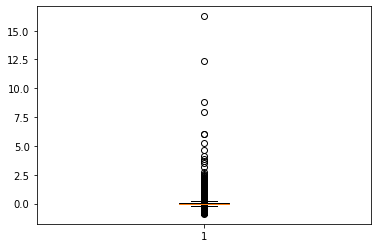

In [ ]:
# check outliers in the target variable
plt.boxplot(returns_ff["ret-rf"]);

I can see that the ret-rf column is wildely dispersed. So I will use winsorizing to adjust extreme values.

In [ ]:
# winsorizing in 0.01 quantile and 0.99 quantile of the data
returns_ff["ret-rf_win"] = winsorize(returns_ff["ret-rf"], (0.01, 0.01))

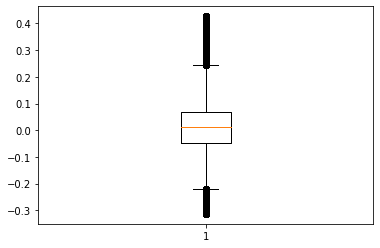

In [ ]:
plt.boxplot(returns_ff["ret-rf_win"]);

After winsorizing, the box in the plot became bigger.

In [ ]:
# make an empty dataframe that I will save modeling result
ff_results = pd.DataFrame(columns = ["tic", "mrkrf", "smb", "hml"])
ff_results

,tic,mrkrf,smb,hml


I will use a for loop to iterate Fama French model over companies in the dataset. I made an iterable array of unique ticker for this.

In [ ]:
print(returns_ff.tic.nunique())

# make iterable ticker array
companies = returns_ff.tic.unique()

1923


In [ ]:
for company in companies:
  # construct X and y
  subset = returns_ff[returns_ff.tic == company]
  X = subset[["mktrf", "smb", "hml"]]
  X = sm.add_constant(X, has_constant="add")
  y = subset["ret-rf_win"]

  # define and fit the model
  model = sm.OLS(y, X).fit()

  # save the result into results dataframe
  result = [company, model.params.mktrf, model.params.smb, model.params.hml]
  ff_results.loc[ff_results.shape[0]] = result

In [ ]:
# check the final result
ff_results

,tic,mrkrf,smb,hml
0,JJSF,0.452887,0.356829,0.524302
1,PLXS,0.955657,0.229663,0.598402
2,ORCL,0.839476,-0.587083,0.016158
3,MSFT,0.935809,-0.330320,-0.401040
4,TROW,1.121489,0.008855,0.145466
...,...,...,...,...
1918,TT,0.895239,-0.775622,0.525388
1919,HWM,0.793835,0.801244,1.009907
1920,PRG,0.629097,-0.713688,-0.055775
1921,BTX,3.810493,4.209570,-2.696020


In [ ]:
# check if the result has missing values in it
ff_results.isna().sum()

tic      0
mrkrf    0
smb      0
hml      0
dtype: int64

Before I save the result into a csv file, I did some exploratory analysis on coefficients.

In [ ]:
# descriptive statistics
ff_results.describe()

,mrkrf,smb,hml
count,1923.000000,1923.000000,1923.000000
mean,0.989574,0.568966,0.273227
std,0.443039,0.768637,0.604085
min,-2.671964,-3.645045,-2.696020
25%,0.706680,0.015952,-0.057036
50%,0.979174,0.491420,0.317552
75%,1.266223,0.987120,0.671159
max,3.810493,4.300571,2.946563


In [ ]:
# number of companies that have positive coefficient for smb
ff_results[ff_results["smb"] > 0 ].tic.count()

1456

([<matplotlib.patches.Wedge at 0x7f9a084d9450>,
 [Text(-0.7950921064279628, 0.7601503419034588, 'small firm'),
  Text(0.795092106427963, -0.7601503419034585, 'large firm')],
 [Text(-0.43368660350616145, 0.4146274592200684, '75.7%'),
  Text(0.4336866035061616, -0.4146274592200682, '24.3%')])

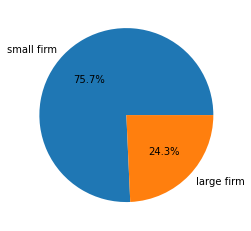

In [ ]:
# construct a pie chart to see the proportion
size = [1456, 1923 - 1456]
size_label = ["small firm", "large firm"]

plt.pie(size, labels = size_label, autopct='%1.1f%%')

In [ ]:
# number of companies that have positive coefficient for hml
ff_results[ff_results["hml"] > 0 ].tic.count()

1385

([<matplotlib.patches.Wedge at 0x7f9a0849ee50>,
 [Text(-0.7017754105750239, 0.8470603715864984, 'value stock'),
  Text(0.7017753312675052, -0.8470604372914506, 'growth stock')],
 [Text(-0.3827865875863767, 0.46203292995627177, '72.0%'),
  Text(0.38278654432773007, -0.46203296579533665, '28.0%')])

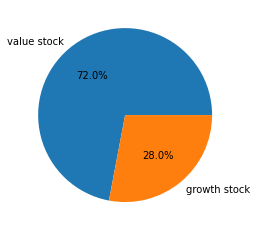

In [ ]:
# construct pie chart to see proportion
value = [1385, 1923-1385]
value_label = ["value stock", "growth stock"]

plt.pie(value, labels = value_label, autopct='%1.1f%%')

In [ ]:
# save the result into a csv file
returns_ff.to_csv("FF_Exposures.csv")

# Calculate Financial Ratios

In this step, I will generate financial ratios using accounting data collected from WRDS - Compustat.

In [ ]:
financials.columns

Index(['tic', 'act', 'at', 'ceq', 'cogs', 'csho', 'invt', 'lct', 'lt', 'ni',
       're', 'revt', 'prcc_c'],
      dtype='object')

In [ ]:
# first market related metrics
financials["market_value"] = financials["csho"] * financials["prcc_c"]
financials["per"] = financials["market_value"] / financials["ni"]
financials["pbr"] = financials["market_value"] / financials["ceq"]

# to ensure good behavior of market ratled ratio, I will use inverted values
financials["e/p"] = financials["per"].apply(np.reciprocal)
financials["book/p"] = financials["pbr"].apply(np.reciprocal)

# profitability ratios
financials["roa"] = financials["ni"] / financials["at"]
financials["roe"] = financials["ni"] / financials["ceq"]

# liquidity rations
financials["current_ratio"] = financials["act"] / financials["lct"]
financials["quick_ratio"] = (financials["act"] - financials["invt"]) / financials["lct"]

# debt management ratio
financials["debt_ratio"] = financials["lt"] / financials["at"]
financials["debt_to_equity"] = financials["lt"] / financials["ceq"]

# leverage
financials["leverage"] = financials["at"] / financials["ceq"]

# Working Capital / Total Assets
financials["working_capital/at"] = (financials["act"] - financials["lct"]) / financials["at"]

# gross profit margin
financials["gross_margin"] = (financials["revt"] - financials["cogs"]) / financials["revt"]

# Retained Earning / Total Assets
financials["re/at"] = financials["re"] / financials["at"]

# Total assets turnover
financials["assets_turnover"] = financials["revt"] / financials["at"]

In [ ]:
ratios = ["tic", "e/p", "book/p", "roa", "roe", "current_ratio", "debt_ratio", "quick_ratio",
          "leverage", "debt_to_equity", "working_capital/at", "gross_margin", "re/at", "assets_turnover"]

financial_ratios = financials[ratios]

## Handle missing values in ratios

In [ ]:
financial_ratios.isna().sum()

tic                    0
e/p                    0
book/p                 0
roa                    0
roe                    0
current_ratio          0
debt_ratio             0
quick_ratio            0
leverage               0
debt_to_equity         0
working_capital/at     0
gross_margin          17
re/at                  0
assets_turnover        0
dtype: int64

There are several missing values in gross_maring and invt_ratio. Let's investigate related columns and see why this is happening.

In [ ]:
financials[financial_ratios["gross_margin"].isna()][["tic", "revt", "cogs", "gross_margin"]]

,tic,revt,cogs,gross_margin
515,CVM,0.0,0.0,NaN
673,AGIO,0.0,0.0,NaN
737,CBAY,0.0,0.0,NaN
755,ALDX,0.0,0.0,NaN
772,NG,0.0,0.0,NaN
793,VKTX,0.0,0.0,NaN
978,KURA,0.0,0.0,NaN
988,AXSM,0.0,0.0,NaN
1025,MDGL,0.0,0.0,NaN
1109,KALV,0.0,0.0,NaN


These companies do not have revt and cogs, so could not calculate the profit margin. When I investigated industry sector at Yahoo Finance, 15 companies were in healthcare - biotechnology industry. The rest two are in Basic material - gold and Energy - Uranium. There companies require a lot of time to develop their products or service. It is possible that these companies have not started selling their products yet. 


I will use machine learning model, just like I did to impute financial data, to predict and replace missing values in this ratio.

In [ ]:
# generate subset of data frame that has missing values in gross margin
gross_margin_imput_target = financial_ratios[financial_ratios["gross_margin"].isna()]
gross_margin_imput_target

,tic,e/p,book/p,roa,roe,current_ratio,debt_ratio,quick_ratio,leverage,debt_to_equity,working_capital/at,gross_margin,re/at,assets_turnover
515,CVM,-0.118529,0.184288,-0.479254,-0.643170,11.499111,0.254857,10.989332,1.342024,0.342024,0.544813,NaN,-5.512007,0.0
673,AGIO,0.898517,0.723407,1.116140,1.242064,17.788771,0.101382,17.788771,1.112820,0.112820,0.698602,NaN,-0.166900,0.0
737,CBAY,-0.314446,0.464471,-0.444834,-0.676997,10.405042,0.342930,10.405042,1.521909,0.521909,0.853770,NaN,-3.790414,0.0
755,ALDX,-0.248687,0.885556,-0.247820,-0.280826,19.771747,0.117532,19.771747,1.133185,0.133185,0.947859,NaN,-1.264029,0.0
772,NG,-0.017776,0.034329,-0.203850,-0.517820,38.660963,0.606330,38.660963,2.540201,1.540201,0.830105,NaN,-9.969495,0.0
793,VKTX,-0.152775,0.560881,-0.261034,-0.272384,23.983595,0.041669,23.983595,1.043480,0.043480,0.957695,NaN,-1.062038,0.0
978,KURA,-0.139984,0.543567,-0.244295,-0.257528,23.259363,0.051385,23.259363,1.054168,0.054168,0.935929,NaN,-0.814074,0.0
988,AXSM,-0.091272,0.010940,-1.485482,-8.343122,3.751051,0.821951,3.751051,5.616443,4.616443,0.722823,NaN,-4.661377,0.0
1025,MDGL,-0.166870,0.135311,-0.884807,-1.233235,3.535803,0.282532,3.535803,1.393790,0.393790,0.712855,NaN,-2.441683,0.0
1109,KALV,-0.099708,0.554543,-0.170007,-0.179803,27.037446,0.054483,27.037446,1.057622,0.057622,0.935580,NaN,-0.622279,0.0


In [ ]:
# subset data for train
gross_margin_imput_train = financial_ratios.drop(gross_margin_imput_target.index)
gross_margin_imput_train.shape

(1869, 14)

In [ ]:
# X and y
gmr_X = gross_margin_imput_train.drop(columns=["tic","gross_margin"])
gmr_y = gross_margin_imput_train["gross_margin"]

In [ ]:
# train-test split
gmr_X_train, gmr_X_test, gmr_y_train, gmr_y_test = train_test_split(
    gmr_X, gmr_y, test_size=0.5, random_state=870)

In [ ]:
# initiate and fit the model
reg_gmr = LinearRegression()
reg_gmr.fit(gmr_X_train, gmr_y_train)

# check r sqaured to see model explains much variation in the data
r2_train_gmr = r2_score(gmr_y_train, reg_gmr.predict(gmr_X_train))
r2_test_gmr = r2_score(gmr_y_test, reg_gmr.predict(gmr_X_test))

print("The train R squared is {}, and test R squared is {}".format(r2_train_gmr, r2_test_gmr))

The train R squared is 0.2368609363111236, and test R squared is -3.7482931739996284


The R squred on test data is negative. This means the model performs really bad. So I will try out another method.

In [ ]:
# initiate the random forest model
rf_gmr = RandomForestRegressor(max_depth=8, random_state=870, n_estimators=200, max_features="sqrt")
rf_gmr.fit(gmr_X_train, gmr_y_train)

# r squred
r2_train_gmr2 = r2_score(gmr_y_train, rf_gmr.predict(gmr_X_train))
r2_test_gmr2 = r2_score(gmr_y_test, rf_gmr.predict(gmr_X_test))

print("The train R squared is {}, and test R squared is {}".format(r2_train_gmr2, r2_test_gmr2))

The train R squared is 0.8786441378666041, and test R squared is 0.16512428107162158


This model is overfitted to the train data, but still works better than the previous model. So I will use this model to predict the gross margin ratio.

In [ ]:
# make prediction
gross_margin_target_pred = rf_gmr.predict(gross_margin_imput_target.drop(columns=["tic", "gross_margin"]))

# add result in the data

for index in gross_margin_imput_target.index:
  pred_index = 0
  financial_ratios.loc[index, "gross_margin"] = gross_margin_target_pred[pred_index]
  pred_index += 1

In [ ]:
# sanity check
# these companies probably have loss instead of profit
gross_margin_target_pred

array([ -95.25735789,  -58.06267382, -109.80758519,  -89.86077333,
       -111.25750987,  -94.10939694,  -91.98630589,  -94.48572384,
        -81.78204892,  -84.05395596, -128.63870972,  -56.29108018,
        -82.25790256,  -42.2169281 ,  -80.34899169,  -80.15003261,
       -106.88495908])

In [ ]:
# confirm the data
financial_ratios["gross_margin"].isna().sum()

0

## Handle outliers in ratios

In [ ]:
financial_ratios.describe().T

,count,mean,std,min,25%,50%,75%,max
e/p,1886.0,0.027009,0.136354,-1.891725,0.008113,0.036704,0.076322,0.898517
book/p,1886.0,0.422120,0.424100,-2.056645,0.161112,0.337004,0.613868,7.547555
roa,1886.0,0.023572,0.171422,-1.759213,0.007584,0.034187,0.079409,1.484070
roe,1886.0,0.023312,10.319606,-364.326147,0.027054,0.115155,0.218230,216.142857
current_ratio,1886.0,2.863921,3.321735,0.286242,1.398980,2.351675,3.257239,54.016360
debt_ratio,1886.0,0.631210,0.273683,0.008474,0.459041,0.630963,0.801356,3.517942
quick_ratio,1886.0,-1.806416,82.943739,-2318.781320,0.966298,1.638298,3.239842,54.016360
leverage,1886.0,1.469272,89.376561,-3095.952381,1.770975,2.552746,4.577301,1347.744089
debt_to_equity,1886.0,0.440710,87.973088,-3027.095238,0.756310,1.527741,3.504444,1346.744089
working_capital/at,1886.0,0.180241,0.208327,-0.787286,0.033140,0.120341,0.278371,1.634673


The financial ratios are widely dispersed. According to the descriptive statistics above, the difference between max and 75% quantile are huge. So I will winsorize these data at top 1% and bottom 1% as caps of the data.

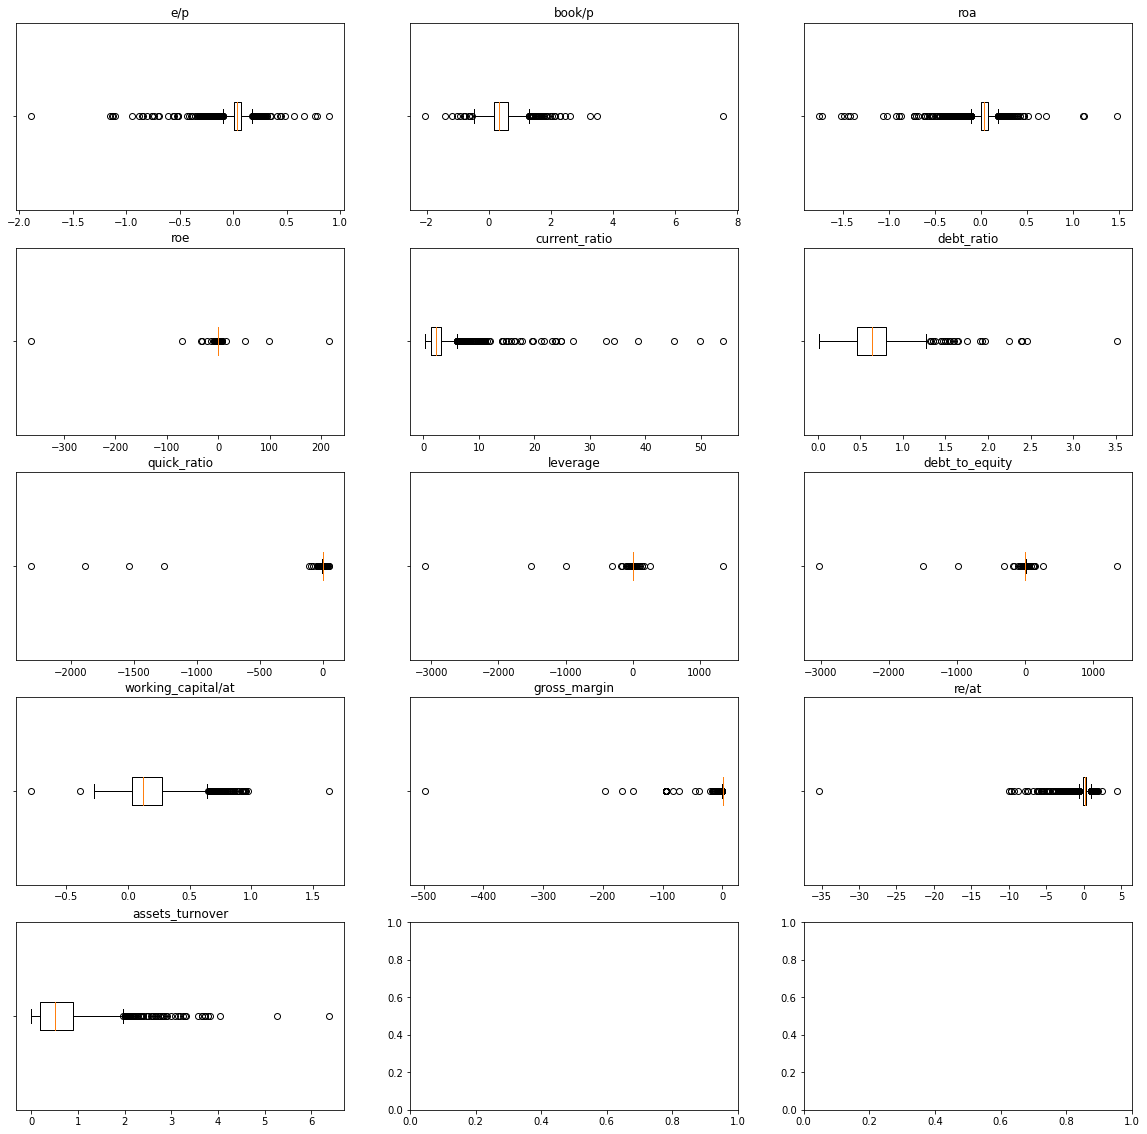

In [ ]:
# boxplots of inversed ratio colums to see distribution of data
# remove tic from ratios list
ratios.remove("tic")

# define subplots, row and column
fig, ax = plt.subplots(5, 3, figsize=(20,20))

i = 0
j = 0

# iterate plotting over ratios list
for col in ratios:
  ax[i, j].boxplot(financial_ratios[col], vert=False)
  ax[i, j].set_title(col)
  ax[i, j].set(yticklabels=[])

  j += 1

  if j == 3:
    i += 1
    j = 0

In [ ]:
# winsorizing ratios column in 0.01 quantile and 0.99 quantile of the data
for col in ratios:
  financial_ratios[col + "_win"] = winsorize(financial_ratios[col], (0.01, 0.01))

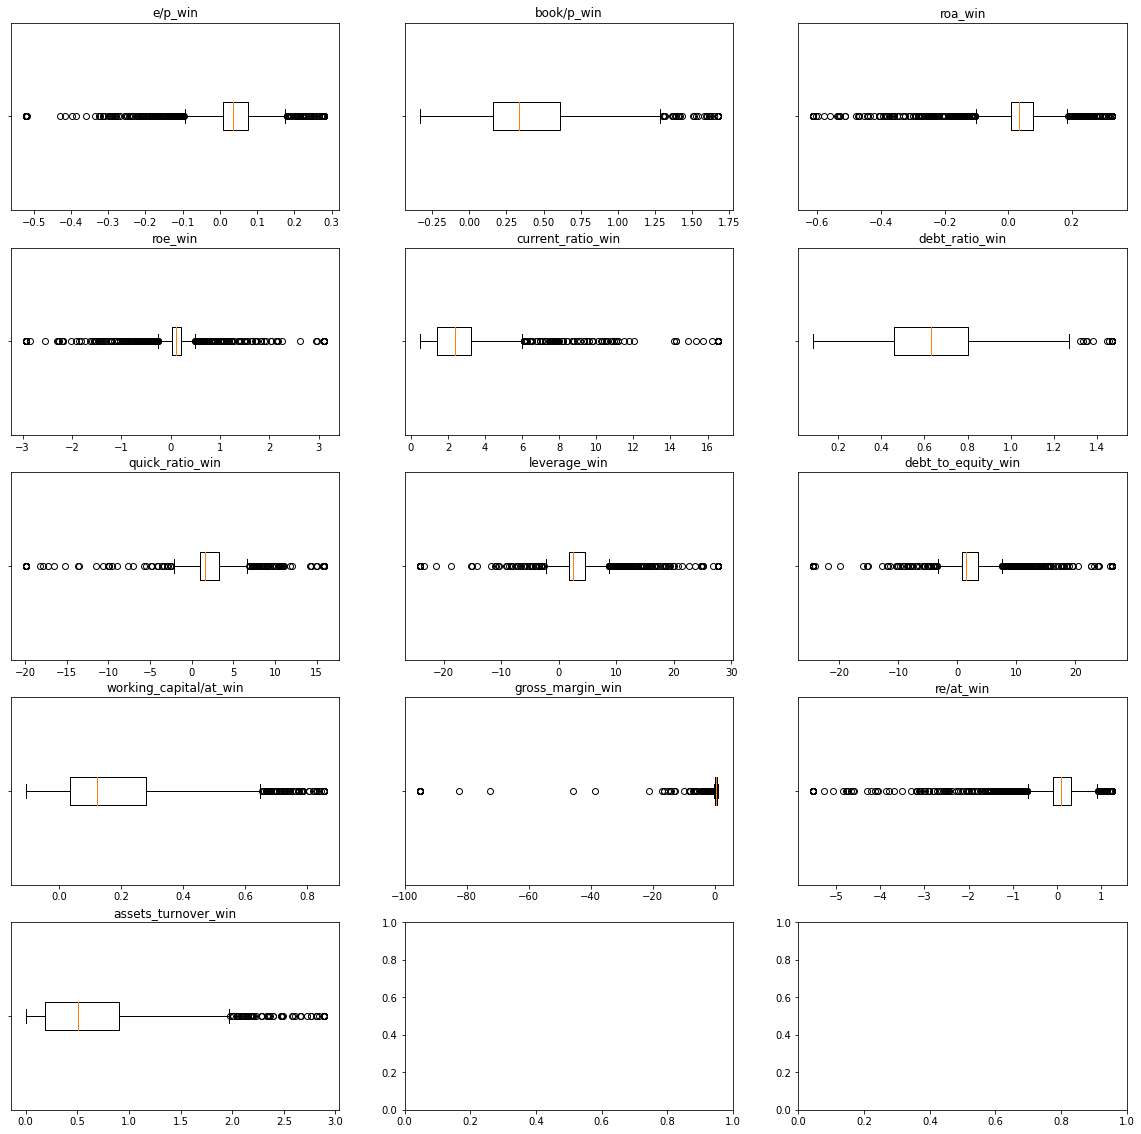

In [ ]:
# boxplots of winsorized columns
win_ratios = ["e/p_win", "book/p_win", "roa_win", "roe_win", "current_ratio_win", "debt_ratio_win",
              "quick_ratio_win", "leverage_win", "debt_to_equity_win", "working_capital/at_win",
              "gross_margin_win", "re/at_win", "assets_turnover_win"]

fig, ax = plt.subplots(5, 3, figsize=(20,20))

i = 0
j = 0

for col in win_ratios:
  ax[i, j].boxplot(financial_ratios[col], vert=False)
  ax[i, j].set_title(col)
  ax[i, j].set(yticklabels=[])

  j += 1

  if j == 3:
    i += 1
    j = 0

In [ ]:
financial_ratios[win_ratios].describe().T

,count,mean,std,min,25%,50%,75%,max
e/p_win,1886.0,0.028873,0.104512,-0.521213,0.008113,0.036704,0.076322,0.279700
book/p_win,1886.0,0.418517,0.357616,-0.337273,0.161112,0.337004,0.613868,1.677414
roa_win,1886.0,0.025727,0.130224,-0.612289,0.007584,0.034187,0.079409,0.325773
roe_win,1886.0,0.103881,0.601425,-2.937806,0.027054,0.115155,0.218230,3.111111
current_ratio_win,1886.0,2.746787,2.280311,0.459936,1.398980,2.351675,3.257239,16.557112
debt_ratio_win,1886.0,0.627146,0.250667,0.086273,0.459041,0.630963,0.801356,1.467325
quick_ratio_win,1886.0,1.943866,3.496757,-19.919132,0.966298,1.638298,3.239842,15.875601
leverage_win,1886.0,3.698315,5.524742,-24.197297,1.770975,2.552746,4.577301,27.667485
debt_to_equity_win,1886.0,2.653235,5.418982,-24.400000,0.756310,1.527741,3.504444,26.187640
working_capital/at_win,1886.0,0.180082,0.202114,-0.108833,0.033140,0.120341,0.278371,0.853392


We can see the box in boxplot got bigger and descriptive statistics also changed.

In [ ]:
# prepare list of columns to save the final results as a csv file
win_ratios.insert(0, "tic")
final_financial_ratios = financial_ratios[win_ratios]

In [ ]:
# check the data
final_financial_ratios.head()

,tic,e/p_win,book/p_win,roa_win,roe_win,current_ratio_win,debt_ratio_win,quick_ratio_win,leverage_win,debt_to_equity_win,working_capital/at_win,gross_margin_win,re/at_win,assets_turnover_win
0,AIR,0.027941,0.760488,0.023251,0.036741,2.782067,0.367149,1.027316,1.580152,0.580152,0.389816,0.173671,0.469832,1.072547
1,AAL,-0.171320,-0.337273,-0.029985,0.271526,0.912133,1.110431,0.817689,-9.055450,-10.055450,-0.025125,0.064018,-0.219357,0.449576
2,PNW,0.077616,0.740913,0.028120,0.104758,0.882877,0.726337,0.673888,3.725445,2.705930,-0.009352,0.382820,0.145881,0.172876
3,ABT,0.028480,0.144202,0.094034,0.197503,1.849599,0.520932,1.456085,2.100330,1.094129,0.148066,0.613999,0.307915,0.572836
4,AMD,0.018205,0.043164,0.254610,0.421769,2.024292,0.396328,1.563208,1.656529,0.656529,0.349706,0.500487,-0.117079,1.323295


In [ ]:
# check the data
final_financial_ratios.shape

(1886, 14)

In [ ]:
# save the result in a csv file
final_financial_ratios.to_csv("Fin-Ratios.csv")

# Industry Indicators

Lastly, I made industry indicator for each company.

In [ ]:
# check the data
industry.head()

,tic,ggroup
0,AIR,2010
1,AAL,2030
2,PNW,5510
3,ABT,3510
4,AMD,4530


In [ ]:
# check the data
industry.ggroup.nunique()

24

In [ ]:
industry.groupby(by="ggroup").tic.count()

ggroup
1010     75
1510     95
2010    183
2020     63
2030     39
2510     25
2520     63
2530     64
2550     86
3010     17
3020     44
3030     17
3510    121
3520    163
4010    179
4020     92
4030     61
4510    118
4520     82
4530     55
5010     13
5020     42
5510     58
6010    131
Name: tic, dtype: int64

There are 24 unique industry groups in the data. We can also see that 2010 and 4010 industry have the most companies.

I will use pandas get_dummies function to turn ggroup data into indicators. This function has parameter "drop_first", which let the first indicator dropped.

In [ ]:
# dummify ggroup
industry = pd.get_dummies(industry, columns=["ggroup"], drop_first=True)
industry.head()

,tic,ggroup_1510,ggroup_2010,ggroup_2020,ggroup_2030,ggroup_2510,ggroup_2520,ggroup_2530,ggroup_2550,ggroup_3010,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,AIR,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AAL,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,PNW,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,ABT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AMD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


We can se that the first ggroup, 1010, is dropped.

In [ ]:
industry.shape

(1886, 24)

In [ ]:
# save as csv
industry.to_csv('Industry.csv')

# Run OLS exploratory for 4 categories

## Risk Regression

* independent variables: 3 Fama French risk factor coefficients calculated in the previous section
* dependent variable: RetYTD in target data

In [ ]:
# check the necessary data
target.head()

,tic,name,retytd
0,A,Agilent Technologies,-0.2080
1,AA,Alcoa Corp,0.4731
2,AAL,American Airlines Gp,0.0579
3,AAN,Aarons Holdings Company,-0.1327
4,AAON,Aaon Inc,-0.3456


In [ ]:
# check the necessary data
ff_results.head()

,tic,mrkrf,smb,hml
0,JJSF,0.452887,0.356829,0.524302
1,PLXS,0.955657,0.229663,0.598402
2,ORCL,0.839476,-0.587083,0.016158
3,MSFT,0.935809,-0.330320,-0.401040
4,TROW,1.121489,0.008855,0.145466


In [ ]:
# merge the datasets on ticker
risk_data = pd.merge(target, ff_results, on='tic', how='left')
risk_data.head()

,tic,name,retytd,mrkrf,smb,hml
0,A,Agilent Technologies,-0.2080,1.014152,-0.253674,-0.143608
1,AA,Alcoa Corp,0.4731,1.694604,0.312097,1.547730
2,AAL,American Airlines Gp,0.0579,1.273449,0.597595,1.179771
3,AAN,Aarons Holdings Company,-0.1327,1.533236,0.226085,0.654775
4,AAON,Aaon Inc,-0.3456,0.516779,0.422130,-0.117068


In [ ]:
# construct X and y
X_risk = risk_data[["mrkrf", "smb", "hml"]]
X_risk["const"] = 1
y = risk_data["retytd"]

In [ ]:
risk_model = sm.OLS(y, X_risk).fit()
risk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 retytd   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     63.15
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           6.72e-39
Time:                        20:34:17   Log-Likelihood:                 76.728
No. Observations:                1886   AIC:                            -145.5
Df Residuals:                    1882   BIC:                            -123.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
mrkrf         -0.0337      0.013     -2.633      0.009      -0.059      -0.009
smb           -0.0033      0.007     -0.461      0.645      -0.017       0.011
hml            0.1230      0.009     13.613      0.000       0.105       0.141
const         -0.0619      0.014     -4.438      0.000      -0.089      -0.035
==============================================================================
Omnibus:                      660.891   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3733.603
Skew:                           1.539   Prob(JB):                         0.00
Kurtosis:                       9.167   Cond. No.                         5.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the regression result, the fama french risk factor coefficients have only 9% of explanatory power. The r squared and adjusted R squared were 0.091 and 0.090 respectively.

The mrkrf has coefficient of -0.0337, which means as mrkrf increase by 1 unit, the retYTD would decrease by 0.0337. The negative coefficient of mrkrf means the company's stock has inverse relationship with the market. If the a stock has inverse relationship, it moves opposite way with the market. The 1886 companies that we used in this regression in average have weak inverse retationship with the overall market.

The smb has coefficient of -0.0033, which means as smb increase by 1 unit, the retYTD would decrease by 0.0033.

The coefficient of hml is 0.1230. This indicates that when hml increase by 1 unit, the retYTD will also increase by 0.1230.


The coefficient of const is -0.0619, and this is the average retYTD when all other variables are equal to 0.

In terms of statistical significance, smb had p-value of 0.645, a lot greater than 0.05. So the coefficient of smb is not statistically significant. Rest have p-value smaller than 0, so coefficients of these variables are statistically different from 0.

## Financial Characteristics

In [ ]:
# check necessary data
final_financial_ratios.head()

,tic,e/p_win,book/p_win,roa_win,roe_win,current_ratio_win,debt_ratio_win,quick_ratio_win,leverage_win,debt_to_equity_win,working_capital/at_win,gross_margin_win,re/at_win,assets_turnover_win
0,AIR,0.027941,0.760488,0.023251,0.036741,2.782067,0.367149,1.027316,1.580152,0.580152,0.389816,0.173671,0.469832,1.072547
1,AAL,-0.171320,-0.337273,-0.029985,0.271526,0.912133,1.110431,0.817689,-9.055450,-10.055450,-0.025125,0.064018,-0.219357,0.449576
2,PNW,0.077616,0.740913,0.028120,0.104758,0.882877,0.726337,0.673888,3.725445,2.705930,-0.009352,0.382820,0.145881,0.172876
3,ABT,0.028480,0.144202,0.094034,0.197503,1.849599,0.520932,1.456085,2.100330,1.094129,0.148066,0.613999,0.307915,0.572836
4,AMD,0.018205,0.043164,0.254610,0.421769,2.024292,0.396328,1.563208,1.656529,0.656529,0.349706,0.500487,-0.117079,1.323295


In [ ]:
finance_data = pd.merge(target, final_financial_ratios, on="tic", how="left")
finance_data.head()

,tic,name,retytd,e/p_win,book/p_win,roa_win,roe_win,current_ratio_win,debt_ratio_win,quick_ratio_win,leverage_win,debt_to_equity_win,working_capital/at_win,gross_margin_win,re/at_win,assets_turnover_win
0,A,Agilent Technologies,-0.2080,0.025079,0.111695,0.113031,0.224531,2.224239,0.496590,1.738290,1.986454,0.986454,0.195329,0.577148,0.006165,0.590285
1,AA,Alcoa Corp,0.4731,0.039111,0.425940,0.028552,0.091824,1.559417,0.581764,0.952529,3.215967,1.870933,0.120000,0.246791,-0.326589,0.808785
2,AAL,American Airlines Gp,0.0579,-0.171320,-0.337273,-0.029985,0.271526,0.912133,1.110431,0.817689,-9.055450,-10.055450,-0.025125,0.064018,-0.219357,0.449576
3,AAN,Aarons Holdings Company,-0.1327,0.143967,0.940491,0.076276,0.153076,3.257239,0.501711,3.257239,2.006869,1.006869,0.324553,0.947060,0.067862,1.280475
4,AAON,Aaon Inc,-0.3456,0.014083,0.111730,0.090372,0.126044,2.513369,0.283014,0.945752,1.394727,0.394727,0.201963,0.309156,0.591076,0.822106


In [ ]:
finance_data.shape

(1886, 16)

In [ ]:
# construct X
X_finance = finance_data.drop(columns=["tic", "name", "retytd"])
X_finance["const"] = 1

In [ ]:
finance_model = sm.OLS(y, X_finance).fit()
finance_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 retytd   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     18.53
Date:                Wed, 27 Apr 2022   Prob (F-statistic):           3.21e-41
Time:                        20:34:17   Log-Likelihood:                 100.46
No. Observations:                1886   AIC:                            -172.9
Df Residuals:                    1872   BIC:                            -95.34
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
e/p_win                   -0.1657      0.079     -2.110      0.035      -0.320      -0.012
book/p_win                 0.1872      0.017     10.819      0.000       0.153       0.221
roa_win                    0.2028      0.079      2.573      0.010       0.048       0.357
roe_win                    0.0053      0.010      0.538      0.590      -0.014       0.025
current_ratio_win         -0.0168      0.004     -4.203      0.000      -0.025      -0.009
debt_ratio_win             0.0665      0.027      2.435      0.015       0.013       0.120
quick_ratio_win            0.0076      0.002      3.862      0.000       0.004       0.011
leverage_win               0.0699      0.023      2.991      0.003       0.024       0.116
debt_to_equity_win        -0.0747      0.024     -3.123      0.002      -0.122      -0.028
working_capital/at_win    -0.0958      0.045     -2.113      0.035      -0.185      -0.007
gross_margin_win          -0.0017      0.001     -2.975      0.003      -0.003      -0.001
re/at_win                  0.0077      0.009      0.883      0.377      -0.009       0.025
assets_turnover_win       -0.0008      0.011     -0.071      0.943      -0.023       0.021
const                     -0.1969      0.037     -5.300      0.000      -0.270      -0.124
==============================================================================
Omnibus:                      694.551   Durbin-Watson:                   2.032
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4180.637
Skew:                           1.608   Prob(JB):                         0.00
Kurtosis:                       9.547   Cond. No.                         203.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the regression result, the financial ratios have only about 10% of explanatory power. The r squared and adjusted R squared were 0.114 and 0.108 respectively.

In terms of coefficients of independent variables, the roa_win had the highest coefficient, 0.2028. This means when roa_win increase by 1 unit, retYTD would also increase by 0.2028. e/p_win, on the other hand, had the lowest coefficient, - 0.1657. This indicates that the return will decrease by 0.1657 when e/p increase by 1 unit.

Regarding the statistical significance, roe_win, re/at_win, and assets_turnover_win had p-value greater than 0.05. Therefore, coefficients of these values are not statistically different from 0.

## Industry Dummies

In [ ]:
# check data
industry.head()

,tic,ggroup_1510,ggroup_2010,ggroup_2020,ggroup_2030,ggroup_2510,ggroup_2520,ggroup_2530,ggroup_2550,ggroup_3010,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,AIR,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AAL,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,PNW,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,ABT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AMD,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
industry_data = pd.merge(target, industry, on="tic", how="inner")
industry_data.head()

,tic,name,retytd,ggroup_1510,ggroup_2010,ggroup_2020,ggroup_2030,ggroup_2510,ggroup_2520,ggroup_2530,...,ggroup_4010,ggroup_4020,ggroup_4030,ggroup_4510,ggroup_4520,ggroup_4530,ggroup_5010,ggroup_5020,ggroup_5510,ggroup_6010
0,A,Agilent Technologies,-0.2080,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AA,Alcoa Corp,0.4731,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AAL,American Airlines Gp,0.0579,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AAN,Aarons Holdings Company,-0.1327,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AAON,Aaon Inc,-0.3456,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
industry_data.shape

(1886, 26)

In [ ]:
# Construct X
X_industry = industry_data.drop(columns=["tic", "name", "retytd"])
X_industry["const"] = 1

In [ ]:
# model
industry_model = sm.OLS(y, X_industry).fit()
industry_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 retytd   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     39.07
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          6.29e-141
Time:                        20:34:18   Log-Likelihood:                 357.63
No. Observations:                1886   AIC:                            -667.3
Df Residuals:                    1862   BIC:                            -534.2
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ggroup_1510    -0.4572      0.031    -14.692      0.000      -0.518      -0.396
ggroup_2010    -0.6056      0.028    -21.924      0.000      -0.660      -0.551
ggroup_2020    -0.5502      0.034    -15.980      0.000      -0.618      -0.483
ggroup_2030    -0.5825      0.040    -14.646      0.000      -0.660      -0.504
ggroup_2510    -0.7230      0.047    -15.540      0.000      -0.814      -0.632
ggroup_2520    -0.7236      0.034    -21.018      0.000      -0.791      -0.656
ggroup_2530    -0.5776      0.034    -16.849      0.000      -0.645      -0.510
ggroup_2550    -0.6663      0.032    -20.932      0.000      -0.729      -0.604
ggroup_3010    -0.4367      0.054     -8.070      0.000      -0.543      -0.331
ggroup_3020    -0.4763      0.038    -12.449      0.000      -0.551      -0.401
ggroup_3030    -0.6688      0.054    -12.359      0.000      -0.775      -0.563
ggroup_3510    -0.5815      0.030    -19.639      0.000      -0.640      -0.523
ggroup_3520    -0.6790      0.028    -24.154      0.000      -0.734      -0.624
ggroup_4010    -0.6029      0.028    -21.756      0.000      -0.657      -0.549
ggroup_4020    -0.6375      0.031    -20.342      0.000      -0.699      -0.576
ggroup_4030    -0.5113      0.035    -14.719      0.000      -0.579      -0.443
ggroup_4510    -0.6237      0.030    -20.963      0.000      -0.682      -0.565
ggroup_4520    -0.6871      0.032    -21.346      0.000      -0.750      -0.624
ggroup_4530    -0.7678      0.036    -21.470      0.000      -0.838      -0.698
ggroup_5010    -0.5032      0.061     -8.314      0.000      -0.622      -0.384
ggroup_5020    -0.5859      0.039    -15.090      0.000      -0.662      -0.510
ggroup_5510    -0.4743      0.035    -13.464      0.000      -0.543      -0.405
ggroup_6010    -0.5509      0.029    -18.884      0.000      -0.608      -0.494
const           0.5150      0.023     22.140      0.000       0.469       0.561
==============================================================================
Omnibus:                      403.265   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2314.656
Skew:                           0.877   Prob(JB):                         0.00
Kurtosis:                       8.136   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

According to the regression result, the industry indicators had the highest explanatory power, which is about 32%. The r squared and adjusted R squared were 0.326 and 0.317 respectively.

In this regression, the coefficient of const means the average of retYTD of industry 1010, because we dropped that industry when we generated indicators. The coefficients of other variables here are the difference between the average retYTD of that specific industry with the industry 1010.

The industry has the highest average retYTD is 1010, recorded as const in the regression. We can see that all other industry have negative coefficients, which means those industry have lower average of retYTD. Industry 4530, on the other hand, has the lowest average retYTD. It has the lowest coefficient, -0.7678. Since coefficients in this regression means the difference between average retYTD of industry 1010 and other industry, we can notice that industry 4530 has the lowest average retYTD.

All variables had p-value of 0.000. Therefore, we can say that all coefficients are statistically different from 0.

## Combined Regression
In this part, I will combine all three independent data sets and regress on retYTD.


In [ ]:
comprehensive_data = pd.merge(industry, final_financial_ratios, on="tic", how="inner")
comprehensive_data = pd.merge(comprehensive_data, ff_results, on="tic", how="inner")
comprehensive_data = pd.merge(target, comprehensive_data, on="tic", how="left")
comprehensive_data.head()

,tic,name,retytd,ggroup_1510,ggroup_2010,ggroup_2020,ggroup_2030,ggroup_2510,ggroup_2520,ggroup_2530,...,quick_ratio_win,leverage_win,debt_to_equity_win,working_capital/at_win,gross_margin_win,re/at_win,assets_turnover_win,mrkrf,smb,hml
0,A,Agilent Technologies,-0.2080,0,0,0,0,0,0,0,...,1.738290,1.986454,0.986454,0.195329,0.577148,0.006165,0.590285,1.014152,-0.253674,-0.143608
1,AA,Alcoa Corp,0.4731,1,0,0,0,0,0,0,...,0.952529,3.215967,1.870933,0.120000,0.246791,-0.326589,0.808785,1.694604,0.312097,1.547730
2,AAL,American Airlines Gp,0.0579,0,0,0,1,0,0,0,...,0.817689,-9.055450,-10.055450,-0.025125,0.064018,-0.219357,0.449576,1.273449,0.597595,1.179771
3,AAN,Aarons Holdings Company,-0.1327,0,0,0,0,0,0,0,...,3.257239,2.006869,1.006869,0.324553,0.947060,0.067862,1.280475,1.533236,0.226085,0.654775
4,AAON,Aaon Inc,-0.3456,0,1,0,0,0,0,0,...,0.945752,1.394727,0.394727,0.201963,0.309156,0.591076,0.822106,0.516779,0.422130,-0.117068


In [ ]:
comprehensive_data.shape

(1886, 42)

In [ ]:
X_comprehensive = comprehensive_data.drop(columns=["tic", "name", "retytd"])
X_comprehensive["const"] = 1

In [ ]:
comprehensive_model = sm.OLS(y, X_comprehensive).fit()
comprehensive_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 retytd   R-squared:                       0.392
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     30.50
Date:                Wed, 27 Apr 2022   Prob (F-statistic):          4.37e-169
Time:                        20:34:18   Log-Likelihood:                 455.24
No. Observations:                1886   AIC:                            -830.5
Df Residuals:                    1846   BIC:                            -608.8
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
ggroup_1510               -0.4202      0.032    -13.316      0.000      -0.482      -0.358
ggroup_2010               -0.5483      0.029    -19.199      0.000      -0.604      -0.492
ggroup_2020               -0.4985      0.035    -14.275      0.000      -0.567      -0.430
ggroup_2030               -0.5642      0.039    -14.380      0.000      -0.641      -0.487
ggroup_2510               -0.6811      0.045    -15.020      0.000      -0.770      -0.592
ggroup_2520               -0.6571      0.035    -18.556      0.000      -0.727      -0.588
ggroup_2530               -0.5187      0.035    -14.857      0.000      -0.587      -0.450
ggroup_2550               -0.6051      0.033    -18.473      0.000      -0.669      -0.541
ggroup_3010               -0.3731      0.057     -6.550      0.000      -0.485      -0.261
ggroup_3020               -0.4377      0.039    -11.116      0.000      -0.515      -0.360
ggroup_3030               -0.6162      0.054    -11.454      0.000      -0.722      -0.511
ggroup_3510               -0.4625      0.032    -14.590      0.000      -0.525      -0.400
ggroup_3520               -0.5033      0.033    -15.222      0.000      -0.568      -0.438
ggroup_4010               -0.6595      0.031    -21.082      0.000      -0.721      -0.598
ggroup_4020               -0.6321      0.033    -19.092      0.000      -0.697      -0.567
ggroup_4030               -0.5563      0.037    -14.945      0.000      -0.629      -0.483
ggroup_4510               -0.5027      0.032    -15.605      0.000      -0.566      -0.439
ggroup_4520               -0.6062      0.033    -18.418      0.000      -0.671      -0.542
ggroup_4530               -0.6552      0.037    -17.762      0.000      -0.728      -0.583
ggroup_5010               -0.5092      0.059     -8.564      0.000      -0.626      -0.393
ggroup_5020               -0.5236      0.039    -13.456      0.000      -0.600      -0.447
ggroup_5510               -0.4758      0.038    -12.506      0.000      -0.550      -0.401
ggroup_6010               -0.5214      0.031    -17.071      0.000      -0.581      -0.462
e/p_win                   -0.0132      0.068     -0.195      0.846      -0.146       0.120
book/p_win                 0.1139      0.017      6.519      0.000       0.080       0.148
roa_win                    0.1669      0.068      2.452      0.014       0.033       0.301
roe_win                   -0.0028      0.008     -0.337      0.736      -0.019       0.014
current_ratio_win         -0.0087      0.004     -2.472      0.014      -0.016      -0.002
debt_ratio_win             0.1257      0.026      4.783      0.000       0.074       0.177
quick_ratio_win            0.0026      0.002      1.496      0.135      -0.001       0.006
leverage_win               0.0394      0.020      1.936      0.053      -0.001  

The combined model had the highest explanatory power. This model had R squared and adjusted R squared of 0.392 and 0.379 respectively. Even though I combined all 3 dataset of dependent variables, the model's explanatory power did not increase much. Considering dynamicity of the market and unexpectability of human's nature, it is inevitable to have only small explanatory power.

Speaking of individual variables, most of them have negative coefficient, which indicates these variables have negative correlation with the retYTD. Ggroup_4530 had the lowest coefficient of -0.6552. Roa_win, on the other hand, had the greatest coefficient of 0.1257 except for the const. In this regression, the coefficient of const means industry 1010 with all other variables at 0.

A few variables have statistically insignificant coefficient. e/p_win, roe_win, quick_ratio_win, leverage_win, debt_to_equity_win, working_capital/_win, and assets_turnover_win had p-value greater or equal to 0.05. Thus, coefficients of these variables are statistically not different from 0.

